In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# 데이터
df = pd.read_csv(
    r"C:\ai\lecNote\1st_Project\data\서울_일반음식점_전처리_폐업률머지.csv",
    low_memory=False
)

# 타겟
y = df["폐업률_3년이내_pct"]

# ===============================
# 📌 모델에 넣을 전체 피처 집합
# ===============================
X = df[
    [
        "업태_그룹",
        "구",
        "시설총규모"   # ✅ 추가
    ]
]


In [3]:

# ===============================
# 📌 범주형 컬럼 정의
# ===============================
cat_cols = [
    "업태_그룹",
    "구"      
]


# ===============================
# 📌 전처리 파이프라인 정의
# ===============================
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [4]:
# ===============================
# 📌 학습 / 테스트 데이터 분리
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [5]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(
        steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=200,   # 트리 개수 (많을수록 안정적)
            max_depth=15,     # 트리 깊이
            random_state=42,   # 재현성
            n_jobs=-1          # CPU 전부 사용 (속도 ↑)
        ))
        ]
)

rf_model.fit(X_train, y_train)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['업태_그룹', '구'])])),
                ('model',
                 RandomForestRegressor(max_depth=15, n_estimators=200,
                                       n_jobs=-1, random_state=42))])

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE : {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")




MAE : 0.66%
RMSE: 1.19%


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False


# 🔹 전처리 객체 가져오기
preprocess_fitted = rf_model.named_steps["preprocess"]

cat_features = preprocess_fitted.named_transformers_["cat"].get_feature_names_out(cat_cols)

# ✅ 최종 전체 피처명 (원핫 + 수치 1개)
feature_names = list(cat_features) + ["시설총규모"]

# 🔹 최종 전체 피처명
feature_names =  list(cat_features)


In [8]:
# 🔹 RandomForest 모델
rf = rf_model.named_steps["model"]

# 🔹 중요도 DataFrame
importances = pd.DataFrame({
    "feature": feature_names,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

importances.head(10)


,feature,importance
1,업태_그룹_분식/간편식,0.337004
29,구_종로구,0.140576
8,구_강동구,0.086915
27,구_용산구,0.069736
25,구_양천구,0.044192
0,업태_그룹_기타,0.043958
26,구_영등포구,0.037271
30,구_중구,0.033007
6,업태_그룹_한식,0.027302
21,구_서초구,0.022312


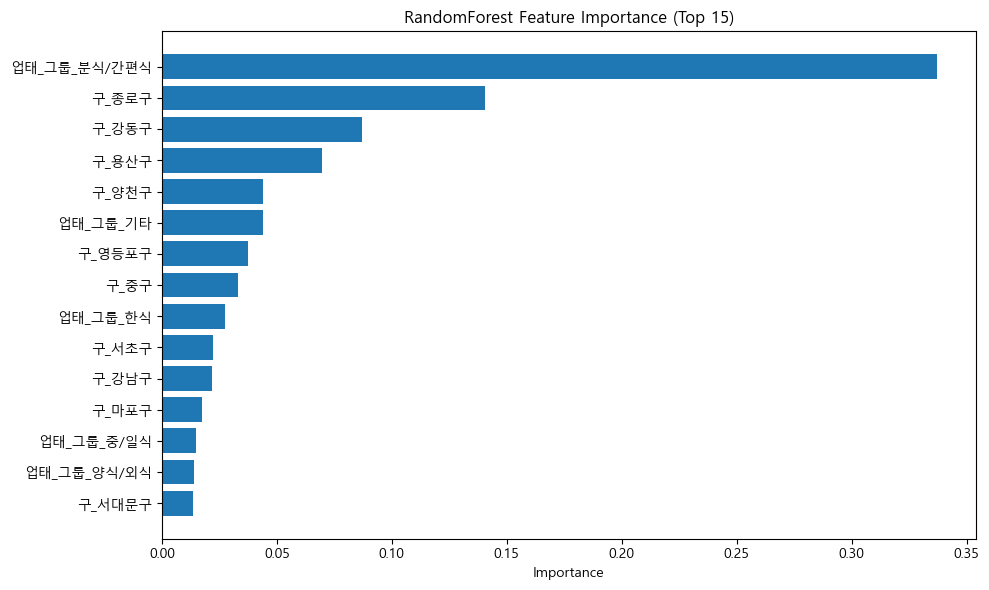

In [9]:
plt.figure(figsize=(10, 6))
plt.barh(
    importances.head(15)["feature"][::-1],
    importances.head(15)["importance"][::-1]
)
plt.title("RandomForest Feature Importance (Top 15)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [10]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

xgb_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", XGBRegressor(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ]
)


In [12]:
xgb_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['업태_그룹', '구'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_typ...hts=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 🔹 RandomForest
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)

# 🔹 XGBoost
xgb_pred = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)

print("📌 RandomForest")
print(f"MAE : {rf_mae:.2f}%")
print(f"RMSE: {rf_rmse:.2f}%")

print("\n📌 XGBoost")
print(f"MAE : {xgb_mae:.2f}%")
print(f"RMSE: {xgb_rmse:.2f}%")


📌 RandomForest
MAE : 0.66%
RMSE: 1.19%

📌 XGBoost
MAE : 0.06%
RMSE: 0.08%


In [14]:
from sklearn.metrics import r2_score
import numpy as np


In [15]:
def regression_summary(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n📊 {model_name} Summary")
    print("-" * 30)
    print(f"MAE  : {mae:.2f}%")
    print(f"RMSE : {rmse:.2f}%")
    print(f"R²   : {r2:.3f}")
    print(f"MAPE : {mape:.2f}%")

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape
    }


In [16]:
print("\n==============================")
print("📌 모델 성능 요약 (Summary)")
print("==============================")

rf_summary = regression_summary(
    y_test,
    rf_pred,
    model_name="RandomForest"
)

xgb_summary = regression_summary(
    y_test,
    xgb_pred,
    model_name="XGBoost"
)



📌 모델 성능 요약 (Summary)

📊 RandomForest Summary
------------------------------
MAE  : 0.66%
RMSE : 1.19%
R²   : 0.942
MAPE : 2.11%

📊 XGBoost Summary
------------------------------
MAE  : 0.06%
RMSE : 0.08%
R²   : 1.000
MAPE : 0.18%


In [17]:
summary_df = pd.DataFrame(
    [rf_summary, xgb_summary],
    index=["RandomForest", "XGBoost"]
)

summary_df


,MAE,RMSE,R2,MAPE
RandomForest,0.656632,1.185360,0.941650,2.112534
XGBoost,0.055756,0.078876,0.999742,0.176315


In [18]:
# ===============================
# 📌 RandomForest 예측
# ===============================
rf_pred = rf_model.predict(X_test)

# ===============================
# 📌 XGBoost 예측
# ===============================
xgb_pred = xgb_model.predict(X_test)

# 결과 확인
print("RF 예측값 샘플:", rf_pred[:5])
print("XGB 예측값 샘플:", xgb_pred[:5])


RF 예측값 샘플: [38.         38.         32.56460657 37.5        32.82120472]
XGB 예측값 샘플: [38.004036 38.004036 30.409603 37.500347 32.021137]


In [19]:
# ===============================
# 📌 실제값 vs 예측값 비교
# ===============================
result_df = X_test.copy()

result_df["실제_폐업률"] = y_test
result_df["RF_예측_폐업률"] = rf_pred
result_df["XGB_예측_폐업률"] = xgb_pred

# 🔹 출력용 컬럼 (% 붙인 문자열)
for col in ["실제_폐업률", "RF_예측_폐업률", "XGB_예측_폐업률"]:
    result_df[col + "_표시"] = result_df[col].map(lambda x: f"{x:.2f}%")

result_df.head()


,업태_그룹,구,시설총규모,실제_폐업률,RF_예측_폐업률,XGB_예측_폐업률,실제_폐업률_표시,RF_예측_폐업률_표시,XGB_예측_폐업률_표시
233631,한식,강동구,29.70,38.0,38.000000,38.004036,38.00%,38.00%,38.00%
186249,한식,강동구,81.70,38.0,38.000000,38.004036,38.00%,38.00%,38.00%
93475,한식,성동구,83.06,30.4,32.564607,30.409603,30.40%,32.56%,30.41%
88553,한식,양천구,85.95,37.5,37.500000,37.500347,37.50%,37.50%,37.50%
187336,한식,강남구,153.61,32.0,32.821205,32.021137,32.00%,32.82%,32.02%


In [20]:
# ===============================
# 📌 실제 예측용 입력 데이터 (1건)
# ===============================
new_data = pd.DataFrame([
    {
        "업태_그룹": "분식/간편식",
        "구": "강동구"
    }
])


In [21]:
# ===============================
# 📌 폐업률 예측 (실제 미래 예측)
# ===============================
rf_future_pred = rf_model.predict(new_data)
xgb_future_pred = xgb_model.predict(new_data)


In [22]:
# ===============================
# 📌 예측 결과 테이블
# ===============================
result_pred = new_data.copy()

result_pred["RF_예측_폐업률"] = rf_future_pred
result_pred["XGB_예측_폐업률"] = xgb_future_pred

# 🔹 출력용 컬럼 (% 문자열)
for col in ["RF_예측_폐업률", "XGB_예측_폐업률"]:
    result_pred[col + "_표시"] = result_pred[col].map(lambda x: f"{x:.2f}%")

result_pred


,업태_그룹,구,RF_예측_폐업률,XGB_예측_폐업률,RF_예측_폐업률_표시,XGB_예측_폐업률_표시
0,분식/간편식,강동구,51.7,51.681015,51.70%,51.68%


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# =========================
# 1) 로드 + (구,업태) 유니크 집계
# =========================
path = "data/서울_일반음식점_전처리_폐업률머지.csv"
df = pd.read_csv(path, low_memory=False)

# (구, 업태_그룹) 조합별 실제 폐업률/표본수 1행으로 만들기
g = (df[["구", "업태_그룹", "표본수", "폐업률_3년이내_pct", "시설총규모"]]
     .dropna()
     .groupby(["구", "업태_그룹"], as_index=False)
     .agg(
         표본수=("표본수", "first"),
         actual=("폐업률_3년이내_pct", "first"),
         시설총규모=("시설총규모", "mean")   # ✅ 추가 (mean 대신 median도 가능)
     )
)

X = g[["업태_그룹", "구", "시설총규모"]]   # ✅ 추가
y = g["actual"].astype(float)

# =========================
# 2) 모델(너 노트북과 동일 컨셉) + OOF 예측 만들기
# =========================
cat_cols = ["업태_그룹", "구"]
num_cols = ["시설총규모"]   # ✅ 추가

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)  # ✅ 추가 (스케일링 필요하면 아래로 교체)
    ]
)

base_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[("preprocess", preprocess), ("model", base_model)])

# OOF(교차검증) 예측: 각 샘플은 자기 자신을 학습에 포함하지 않은 모델로 예측됨
kf = KFold(n_splits=5, shuffle=True, random_state=42)
pred_oof = np.empty(len(g), dtype=float)

for tr_idx, va_idx in kf.split(X):
    pipe.fit(X.iloc[tr_idx], y.iloc[tr_idx])
    pred_oof[va_idx] = pipe.predict(X.iloc[va_idx])

g["pred"] = pred_oof
g["error"] = g["pred"] - g["actual"]

# =========================
# 3) 히트맵용 pivot 만들기
# =========================
# 보기 좋게 정렬(원하는 순서가 있으면 여기서 커스텀)
g = g.sort_values(["구", "업태_그룹"]).copy()

pv_actual = g.pivot(index="구", columns="업태_그룹", values="actual")
pv_pred   = g.pivot(index="구", columns="업태_그룹", values="pred")
pv_err    = g.pivot(index="구", columns="업태_그룹", values="error")

# =========================
# 4) 히트맵 그리기 함수
# =========================
def plot_heatmap(pv, title, fmt="{:.1f}", annotate=True):
    arr = pv.values.astype(float)
    masked = np.ma.masked_invalid(arr)

    plt.figure(figsize=(12, 6))
    plt.imshow(masked, aspect="auto")  # 기본 colormap 사용(자동)
    plt.title(title)
    plt.yticks(range(len(pv.index)), pv.index)
    plt.xticks(range(len(pv.columns)), pv.columns, rotation=0)  # x축 가로
    plt.colorbar()
    
    if annotate:
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                if np.isfinite(arr[i, j]):
                    plt.text(j, i, fmt.format(arr[i, j]), ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

# (1) 실제 폐업률 히트맵
plot_heatmap(pv_actual, "(1) 실제 폐업률(%) 히트맵", fmt="{:.1f}", annotate=True)

# (2) 예측 폐업률 히트맵
plot_heatmap(pv_pred, "(2) 예측 폐업률(%) 히트맵 (OOF)", fmt="{:.1f}", annotate=True)

# (3) 오차(예측-실제) 히트맵
plot_heatmap(pv_err, "(3) 오차(예측-실제, %p) 히트맵", fmt="{:+.1f}", annotate=True)


FileNotFoundError: [Errno 2] No such file or directory: 'data/서울_일반음식점_전처리_폐업률머지.csv'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# ===============================
# 0) (윈도우) 한글 폰트
# ===============================
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# ===============================
# 1) 데이터 로드 (업로드된 파일 경로)
# ===============================
path = "data/서울_일반음식점_전처리_폐업률머지.csv"
df = pd.read_csv(path, low_memory=False)

# 노트북에서 쓴 컬럼 기준
df = df.dropna(subset=["구", "업태_그룹", "폐업률_3년이내_pct"]).copy()

X = df[["업태_그룹", "구"]]
y = df["폐업률_3년이내_pct"].astype(float)

# y가 0~1이면 %로 바꿔서 보기 좋게 처리 (이미 %면 그대로)
scale = 100.0 if y.max() <= 1.5 else 1.0
y = y * scale

# ===============================
# 2) (네 노트북 그대로) 전처리 + RandomForest 모델
# ===============================
cat_cols = ["업태_그룹", "구"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# 네 노트북처럼 train/test split 후 학습
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
rf_model.fit(X_train, y_train)

# ===============================
# 3) 구×업태 조합 단위로 실제/예측/오차 만들기
# ===============================
g = (df.assign(_y=y)  # 스케일 적용된 y 사용
       .groupby(["구", "업태_그룹"], as_index=False)
       .agg(
           actual=("_y", "mean"),
           n=("_y", "size")
       ))

g["pred"] = rf_model.predict(g[["업태_그룹", "구"]])
g["error"] = g["pred"] - g["actual"]

pv_actual = g.pivot(index="구", columns="업태_그룹", values="actual")
pv_pred   = g.pivot(index="구", columns="업태_그룹", values="pred")
pv_err    = g.pivot(index="구", columns="업태_그룹", values="error")

# ===============================
# 4) 히트맵 함수 (matplotlib)
# ===============================
def plot_heatmap(pv, title, fmt="{:.1f}", annotate=True, figsize=(12, 6)):
    arr = pv.values.astype(float)
    masked = np.ma.masked_invalid(arr)

    plt.figure(figsize=figsize)
    plt.imshow(masked, aspect="auto")  # 기본 colormap
    plt.title(title)
    plt.yticks(range(len(pv.index)), pv.index)
    plt.xticks(range(len(pv.columns)), pv.columns, rotation=0)  # x축 가로
    plt.colorbar()

    if annotate:
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                if np.isfinite(arr[i, j]):
                    plt.text(j, i, fmt.format(arr[i, j]),
                             ha="center", va="center", fontsize=7)

    plt.tight_layout()
    plt.show()

# ===============================
# 5) 요청한 3개 히트맵
# ===============================
unit = "(%)" if scale == 1.0 else "(%로 변환)"
plot_heatmap(pv_actual, f"(1) 실제 폐업률 히트맵 {unit}", fmt="{:.1f}")
plot_heatmap(pv_pred,   f"(2) 예측 폐업률 히트맵 - RandomForest {unit}", fmt="{:.1f}")
plot_heatmap(pv_err,    f"(3) 오차(예측-실제) 히트맵 - RandomForest (단위 동일)", fmt="{:+.1f}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# (필요시) pip install xgboost
from xgboost import XGBRegressor

# ===============================
# 0) (윈도우) 한글 폰트 (필요할 때만)
# ===============================
# plt.rcParams["font.family"] = "Malgun Gothic"
# plt.rcParams["axes.unicode_minus"] = False

# ===============================
# 1) 데이터 로드
# ===============================
path = "data/서울_일반음식점_전처리_폐업률머지.csv"  # 로컬이면 네 경로로 바꿔줘
df = pd.read_csv(path, low_memory=False)

df = df.dropna(subset=["구", "업태_그룹", "폐업률_3년이내_pct"]).copy()

X = df[["업태_그룹", "구"]].copy()
y_raw = df["폐업률_3년이내_pct"].astype(float).copy()

# y가 0~1이면 %로 변환(안전장치). 이미 %면 그대로
scale = 100.0 if y_raw.max() <= 1.5 else 1.0
y = y_raw * scale

# ===============================
# 2) (네 노트북 그대로) 전처리 + XGBoost
# ===============================
cat_cols = ["업태_그룹", "구"]

preprocess = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)]
)

xgb_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", XGBRegressor(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
xgb_model.fit(X_train, y_train)

# ===============================
# 3) 구×업태 조합 단위 실제/예측/오차 만들기
# ===============================
g = (df.assign(_y=y)
       .groupby(["구", "업태_그룹"], as_index=False)
       .agg(
           actual=("_y", "mean"),   # 조합별 실제 평균(사실 값이 동일하면 mean=first)
           n=("_y", "size")
       ))

g["pred"]  = xgb_model.predict(g[["업태_그룹", "구"]])
g["error"] = g["pred"] - g["actual"]

pv_actual = g.pivot(index="구", columns="업태_그룹", values="actual")
pv_pred   = g.pivot(index="구", columns="업태_그룹", values="pred")
pv_err    = g.pivot(index="구", columns="업태_그룹", values="error")

# ===============================
# 4) 히트맵 그리기
# ===============================
def plot_heatmap(pv, title, fmt="{:.1f}", annotate=True):
    arr = pv.values.astype(float)
    masked = np.ma.masked_invalid(arr)

    n_rows, n_cols = arr.shape
    figsize = (max(10, n_cols * 0.6), max(5, n_rows * 0.35))

    plt.figure(figsize=figsize)
    plt.imshow(masked, aspect="auto")   # 기본 colormap
    plt.title(title)
    plt.yticks(range(len(pv.index)), pv.index)
    plt.xticks(range(len(pv.columns)), pv.columns, rotation=0)  # x축 가로
    plt.colorbar()

    if annotate:
        fs = 7 if (n_rows * n_cols) <= 400 else 5
        for i in range(n_rows):
            for j in range(n_cols):
                v = arr[i, j]
                if np.isfinite(v):
                    plt.text(j, i, fmt.format(v), ha="center", va="center", fontsize=fs)

    plt.tight_layout()
    plt.show()

# 너무 촘촘하면 자동으로 숫자 표시 끄기
auto_annotate = (pv_actual.shape[0] * pv_actual.shape[1]) <= 450
unit = "(%)" if scale == 1.0 else "(%로 변환)"

plot_heatmap(pv_actual, f"(1) 실제 폐업률 히트맵 {unit}", fmt="{:.1f}", annotate=auto_annotate)
plot_heatmap(pv_pred,   f"(2) 예측 폐업률 히트맵 - XGBoost {unit}", fmt="{:.1f}", annotate=auto_annotate)
plot_heatmap(pv_err,    f"(3) 오차(예측-실제) 히트맵 - XGBoost (단위 동일)", fmt="{:+.1f}", annotate=auto_annotate)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# ===============================
# 1) 데이터 로드
# ===============================
df = pd.read_csv(
    "data/서울_일반음식점_전처리_폐업률머지.csv",
    low_memory=False
)

df = df.dropna(subset=["구", "업태_그룹", "폐업률_3년이내_pct"]).copy()

X = df[["업태_그룹", "구"]]
y = df["폐업률_3년이내_pct"].astype(float)

# % 스케일 정리
if y.max() <= 1.5:
    y = y * 100

# ===============================
# 2) XGBoost (네가 쓴 방식 그대로)
# ===============================
preprocess = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), ["업태_그룹", "구"])]
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("xgb", XGBRegressor(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

# ===============================
# 3) 예측
# ===============================
y_pred = model.predict(X_test)

plot_df = pd.DataFrame({
    "actual": y_test.values,
    "pred": y_pred
})

# 👉 예측값 기준 정렬 (선그래프 핵심)
plot_df = plot_df.sort_values("pred").reset_index(drop=True)

# ===============================
# 4) 선그래프 시각화
# ===============================
plt.figure(figsize=(12, 5))

plt.plot(
    plot_df["actual"].values,
    label="Actual (실제 폐업률)",
    linewidth=2
)

plt.plot(
    plot_df["pred"].values,
    label="Predicted (XGBoost 예측)",
    linewidth=2
)

plt.title("Actual vs Predicted 폐업률 (XGBoost)", fontsize=14)
plt.xlabel("샘플 (예측값 기준 정렬)")
plt.ylabel("폐업률 (%)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 1) 데이터 + XGBoost 예측값
#    (앞에서 학습한 model 그대로 사용한다고 가정)
# ===============================
df = pd.read_csv(
    "data/서울_일반음식점_전처리_폐업률머지.csv",
    low_memory=False
)

df = df.dropna(subset=["구", "업태_그룹", "폐업률_3년이내_pct"]).copy()

X_all = df[["업태_그룹", "구"]]
y_raw = df["폐업률_3년이내_pct"].astype(float)

# % 스케일 보정
if y_raw.max() <= 1.5:
    y = y_raw * 100
else:
    y = y_raw

# ▶ XGBoost 예측 (이미 학습된 model 사용)
df["pred"] = model.predict(X_all)
df["actual"] = y

# ===============================
# 2) 구 × 업태 조합 단위로 집계
# ===============================
g = (df.groupby(["구", "업태_그룹"], as_index=False)
       .agg(
           pred=("pred", "mean"),
           actual=("actual", "mean"),
           n=("actual", "size")
       ))

# ===============================
# 3) TOP5 / BOTTOM5 추출
# ===============================
top5_high = g.sort_values("pred", ascending=False).head(5)
top5_low  = g.sort_values("pred", ascending=True).head(5)

# ===============================
# 4) 막대그래프 함수
# ===============================
def plot_bar(df, title):
    labels = df["구"] + " - " + df["업태_그룹"]

    plt.figure(figsize=(8, 4))
    plt.barh(labels, df["pred"])
    plt.xlabel("예측 폐업률 (%)")
    plt.title(title)

    # 값 표시
    for i, v in enumerate(df["pred"]):
        plt.text(v, i, f"{v:.1f}%", va="center", fontsize=9)

    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ===============================
# 5) 시각화
# ===============================
plot_bar(top5_high, "XGBoost 예측 폐업률 TOP 5 (고위험 구×업태)")
plot_bar(top5_low,  "XGBoost 예측 폐업률 BOTTOM 5 (저위험 구×업태)")


In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ============================================
# 1) 데이터 로드
# ============================================
df = pd.read_csv(
    r"C:\ai\lecNote\1st_Project\data\금리시장면적_고용지표수정_인허가일자머지_인구머지_폐업률추가.csv",
    low_memory=False
)

# ============================================
# 2) 타겟 / 피처 (✅ 요청: 구, 창업월, 시설총규모, base_rate, 구별인구)
# ============================================
target_col = "폐업률_3년이내_pct"
feature_cols = ["구", "창업월", "시설총규모", "base_rate", "구별인구"]

# base_late 오타 대응(혹시 파일에 base_late로 있으면 자동 변경)
if "base_rate" not in df.columns and "base_late" in df.columns:
    df = df.rename(columns={"base_late": "base_rate"})

# 필요한 컬럼 체크
need = feature_cols + [target_col]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"❌ df에 필요한 컬럼이 없습니다: {missing}")

# ============================================
# 3) 타입 정리 (숫자형 변환)
# ============================================
df["창업월"] = pd.to_numeric(df["창업월"], errors="coerce")
df["시설총규모"] = pd.to_numeric(df["시설총규모"], errors="coerce")
df["base_rate"] = pd.to_numeric(df["base_rate"], errors="coerce")
df["구별인구"] = pd.to_numeric(df["구별인구"], errors="coerce")
df[target_col] = pd.to_numeric(df[target_col], errors="coerce")

# 결측 제거
df = df.dropna(subset=need).copy()

# (권장) 최소 필터
df = df[(df["시설총규모"] > 0)].copy()

X = df[feature_cols].copy()
y = df[target_col].astype(float).copy()

print("✅ 샘플 수:", len(df))
print("✅ y min/max:", float(y.min()), float(y.max()))

# ============================================
# 4) 전처리 (구=범주형 / 나머지=수치형)
# ============================================
cat_cols = ["구"]
num_cols = ["창업월", "시설총규모", "base_rate", "구별인구"]

# OneHotEncoder 버전 차이 대응
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

# ============================================
# 5) Train/Test split
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# 6) 평가 함수
# ============================================
def reg_report(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:>12} | MAE {mae:.3f} | RMSE {rmse:.3f} | R2 {r2:.3f}")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

# ============================================
# 7) RandomForest
# ============================================
rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=400,
            max_depth=18,
            min_samples_leaf=3,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_sum = reg_report("RF", y_test, rf_pred)

# ============================================
# 8) XGBoost
# ============================================
xgb_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", XGBRegressor(
            n_estimators=1200,
            max_depth=6,
            learning_rate=0.03,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_lambda=5.0,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"
        ))
    ]
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_sum = reg_report("XGB", y_test, xgb_pred)

# ============================================
# 9) 요약
# ============================================
summary = pd.DataFrame([rf_sum, xgb_sum]).set_index("Model").sort_values("MAE")
print("\n==============================")
print("📌 성능 요약")
print("==============================")
display(summary)

# ============================================
# 10) 1건 예측 예시
# ============================================
new_data = pd.DataFrame([{
    "구": "강동구",
    "창업월": 3,
    "시설총규모": 500.0,
    "base_rate": 3.5,
    "구별인구": 500000
}])

print("\n[1건 예측 입력]")
display(new_data)

print("RF 예측 폐업률:", float(rf_model.predict(new_data)[0]))
print("XGB 예측 폐업률:", float(xgb_model.predict(new_data)[0]))


✅ 샘플 수: 237368
✅ y min/max: 16.8 52.2
          RF | MAE 2.617 | RMSE 3.813 | R2 0.445
         XGB | MAE 2.586 | RMSE 3.766 | R2 0.458

📌 성능 요약


,MAE,RMSE,R2
Model,,,
XGB,2.586072,3.765828,0.458269
RF,2.616582,3.813201,0.444553



[1건 예측 입력]


,구,창업월,시설총규모,base_rate,구별인구
0,강동구,3,45.0,3.5,500000


RF 예측 폐업률: 42.984670692639874
XGB 예측 폐업률: 39.34504318237305


In [34]:
# ============================================
# 10) 1건 예측 예시
# ============================================
new_data = pd.DataFrame([{
    "구": "강동구",
    "창업월": 3,
    "시설총규모": 5.0,
    "base_rate": 3.5,
    "구별인구": 500000
}])

print("\n[1건 예측 입력]")
display(new_data)

print("RF 예측 폐업률:", float(rf_model.predict(new_data)[0]))
print("XGB 예측 폐업률:", float(xgb_model.predict(new_data)[0]))



[1건 예측 입력]


,구,창업월,시설총규모,base_rate,구별인구
0,강동구,3,5.0,3.5,500000


RF 예측 폐업률: 44.21885099067604
XGB 예측 폐업률: 42.34974670410156


In [31]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb  # ✅ xgboost.train 사용 (버전 이슈 최소화)

# ============================================
# 1) 데이터 로드
# ============================================
PATH = r"C:\ai\lecNote\1st_Project\data\금리시장면적_고용지표수정_인허가일자머지_인구머지_폐업률추가.csv"
df = pd.read_csv(PATH, low_memory=False)

# base_late 오타 대응
if "base_rate" not in df.columns and "base_late" in df.columns:
    df = df.rename(columns={"base_late": "base_rate"})

target_col = "폐업률_3년이내_pct"
base_features = ["구", "창업월", "시설총규모", "base_rate", "구별인구"]

need = base_features + [target_col]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"❌ df에 필요한 컬럼이 없습니다: {missing}")

# ============================================
# 2) 타입 정리 (숫자형 변환)
# ============================================
df["창업월"] = pd.to_numeric(df["창업월"], errors="coerce")
df["시설총규모"] = pd.to_numeric(df["시설총규모"], errors="coerce")
df["base_rate"] = pd.to_numeric(df["base_rate"], errors="coerce")
df["구별인구"] = pd.to_numeric(df["구별인구"], errors="coerce")
df[target_col] = pd.to_numeric(df[target_col], errors="coerce")

# ✅ dropna를 최소화하고, 뒤에서 imputer로 처리(샘플 수 유지)
# (단, 타겟은 NaN이면 학습 불가)
df = df.dropna(subset=[target_col, "구"]).copy()

# (권장) 말도 안 되는 값 최소 필터
df = df[(df["시설총규모"].fillna(0) >= 0) & (df["구별인구"].fillna(0) >= 0)].copy()

# ============================================
# 3) 피처 엔지니어링 (원본 5개에서 파생)
#    - 창업월: sin/cos (월의 주기성)
#    - 시설총규모/인구: log1p
#    - 인구 대비 규모(밀도 느낌): 규모_per_1만명
# ============================================
m = df["창업월"].fillna(0).astype(int).clip(1, 12)
df["창업월_sin"] = np.sin(2*np.pi*m/12)
df["창업월_cos"] = np.cos(2*np.pi*m/12)

df["시설총규모_log"] = np.log1p(df["시설총규모"].clip(lower=0))
df["구별인구_log"]   = np.log1p(df["구별인구"].clip(lower=0))

# 인구 0이면 분모 보호
pop_safe = df["구별인구"].replace(0, np.nan)
df["규모_per_1만명"] = df["시설총규모"] / (pop_safe / 10000.0)

# 최종 피처
feature_cols = [
    "구",
    "base_rate",
    "창업월_sin", "창업월_cos",
    "시설총규모", "시설총규모_log",
    "구별인구", "구별인구_log",
    "규모_per_1만명",
]

X = df[feature_cols].copy()
y = df[target_col].astype(float).copy()

print(f"✅ 샘플 수: {len(df)} | y min/max: {float(y.min()):.1f} {float(y.max()):.1f}")

# ============================================
# 4) Train/Val/Test (EarlyStopping용 Val 분리)
# ============================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)
print("Split:", len(X_train), len(X_val), len(X_test))

# ============================================
# 5) 전처리: 구 원핫 + 숫자 Impute
#    - OHE는 sparse=True로 (xgboost가 sparse 잘 먹음)
# ============================================
cat_cols = ["구"]
num_cols = [c for c in feature_cols if c not in cat_cols]

# OneHotEncoder 버전 차이 대응
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe),
        ]), cat_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ]), num_cols),
    ],
    remainder="drop"
)

preprocess.fit(X_train)

Xtr = preprocess.transform(X_train)
Xva = preprocess.transform(X_val)
Xte = preprocess.transform(X_test)

# ============================================
# 6) 평가 함수
# ============================================
def reg_report(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:>18} | MAE {mae:.3f} | RMSE {rmse:.3f} | R2 {r2:.3f}")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

# ============================================
# 7) XGBoost: xgboost.train (EarlyStopping 안정)
# ============================================
dtr = xgb.DMatrix(Xtr, label=y_train)
dva = xgb.DMatrix(Xva, label=y_val)
dte = xgb.DMatrix(Xte)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "learning_rate": 0.03,
    "max_depth": 7,
    "min_child_weight": 5,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "reg_lambda": 8.0,
    "reg_alpha": 0.2,
    "gamma": 0.0,
    "seed": 42,
}

watchlist = [(dtr, "train"), (dva, "val")]

booster = xgb.train(
    params=params,
    dtrain=dtr,
    num_boost_round=8000,        # 크게 주고
    evals=watchlist,
    early_stopping_rounds=300,   # ✅ 여기서 early stopping (거의 모든 버전 OK)
    verbose_eval=200
)

xgb_pred = booster.predict(dte)
xgb_sum = reg_report("XGB(train+ES+FE)", y_test, xgb_pred)
print("✅ best_iteration =", booster.best_iteration)

# ============================================
# 8) ExtraTrees (가끔 XGB랑 성향 달라서 앙상블 이득)
#    - ExtraTrees는 sparse를 싫어해서 dense로 변환(구가 25개라 용량 OK)
# ============================================
Xtr_dense = Xtr.toarray() if hasattr(Xtr, "toarray") else Xtr
Xva_dense = Xva.toarray() if hasattr(Xva, "toarray") else Xva
Xte_dense = Xte.toarray() if hasattr(Xte, "toarray") else Xte

et = ExtraTreesRegressor(
    n_estimators=1200,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
et.fit(Xtr_dense, y_train)
et_pred = et.predict(Xte_dense)
et_sum = reg_report("ExtraTrees(FE)", y_test, et_pred)

# ============================================
# 9) 앙상블 가중치 자동 선택 (VAL에서 MAE 최소화)
# ============================================
# VAL 예측도 뽑아서, w*(XGB)+(1-w)*(ET) 최적 w 탐색
xgb_val_pred = booster.predict(dva)
et_val_pred = et.predict(Xva_dense)

best_w, best_mae = None, 1e18
for w in np.linspace(0, 1, 21):  # 0.00 ~ 1.00
    pred = w * xgb_val_pred


✅ 샘플 수: 237368 | y min/max: 16.8 52.2
Split: 166157 35605 35606
[0]	train-rmse:5.05977	val-rmse:5.06047
[200]	train-rmse:3.69758	val-rmse:3.77360
[400]	train-rmse:3.64485	val-rmse:3.76523
[600]	train-rmse:3.60346	val-rmse:3.76790
[676]	train-rmse:3.58985	val-rmse:3.76921
  XGB(train+ES+FE) | MAE 2.579 | RMSE 3.748 | R2 0.457
✅ best_iteration = 376
    ExtraTrees(FE) | MAE 2.807 | RMSE 4.067 | R2 0.360
